In [1]:
!pip install fuzzywuzzy python-Levenshtein


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import geopandas as gpd
import pandas as pd
from datetime import datetime, timezone

# Load GeoJSON files
francine_path = r"C:\Users\colto\Documents\GitHub\Tweet_project\data\geojson\francine.geojson"
helene_path = r"C:\Users\colto\Documents\GitHub\Tweet_project\data\geojson\helene.geojson"

# Load into GeoDataFrames
francine_gdf = gpd.read_file(francine_path)
helene_gdf = gpd.read_file(helene_path)

# Standardize timestamps to UTC
francine_gdf['timestamp'] = pd.to_datetime(francine_gdf['time'], utc=True)
# print(francine_gdf['time'])
helene_gdf['timestamp'] = pd.to_datetime(helene_gdf['time'], utc=True)


# Floor to 4-hour bins
francine_gdf['time_bin'] = francine_gdf['timestamp'].dt.floor('4h')
helene_gdf['time_bin'] = helene_gdf['timestamp'].dt.floor('4h')
all_data = francine_gdf['time_bin'].unique()
francine_gdf['unix_timestamp'] = francine_gdf['time_bin'].astype('int64') // 1000
helene_gdf['unix_timestamp'] = helene_gdf['time_bin'].astype('int64') // 1000
# Create readable bin labels for file naming
francine_gdf['bin_label'] = francine_gdf['time_bin'].dt.strftime('%Y%m%d_%H%M')
helene_gdf['bin_label'] = helene_gdf['time_bin'].dt.strftime('%Y%m%d_%H%M')
# Display summary
print("FRANCINE Dataset:")
print(f"  Total tweets: {len(francine_gdf)}")
print(f"  Time range: {francine_gdf['time_bin'].min()} to {francine_gdf['time_bin'].max()}")
print(f"  Number of 4-hour bins: {francine_gdf['time_bin'].nunique()}")
print(f"\nHELENE Dataset:")
print(f"  Total tweets: {len(helene_gdf)}")
print(f"  Time range: {helene_gdf['time_bin'].min()} to {helene_gdf['time_bin'].max()}")
print(f"  Number of 4-hour bins: {helene_gdf['time_bin'].nunique()}")

FRANCINE Dataset:
  Total tweets: 2303
  Time range: 2024-09-09 08:00:00+00:00 to 2024-09-16 12:00:00+00:00
  Number of 4-hour bins: 42

HELENE Dataset:
  Total tweets: 3007
  Time range: 2024-09-26 00:00:00+00:00 to 2024-09-27 16:00:00+00:00
  Number of 4-hour bins: 11


In [3]:
def validate_city_matching(francine_gdf, helene_gdf, cities_lookup, state_lookup, county_lookup):
    """
    Validate which cities from tweets are found in the cities shapefile
    """
    print("\n" + "="*60)
    print("CITY MATCHING VALIDATION")
    print("="*60)

    # Combine both datasets
    all_tweets = pd.concat([francine_gdf, helene_gdf], ignore_index=True)

    # Extract all unique GPE values (potential cities)
    all_gpe_values = set()
    for gpe in all_tweets['GPE'].dropna():
        gpe_clean = str(gpe).upper().strip()
        if gpe_clean and gpe_clean != 'NAN':
            all_gpe_values.add(gpe_clean)

    print(f"Total unique GPE values in tweets: {len(all_gpe_values)}")

    # Check matches against each lookup
    state_matches = set(gpe for gpe in all_gpe_values if gpe in state_lookup)
    county_matches = set(gpe for gpe in all_gpe_values if gpe in county_lookup)
    city_matches = set(gpe for gpe in all_gpe_values if gpe in cities_lookup)

    # Calculate what's left after state/county matching
    remaining_after_states = all_gpe_values - state_matches
    remaining_after_counties = remaining_after_states - county_matches
    potential_cities = remaining_after_counties
    print(potential_cities)
    print(f"\nMatching Results:")
    print(f"  States matched: {len(state_matches)}")
    print(f"  Counties matched: {len(county_matches)}")
    print(f"  Cities matched: {len(city_matches)}")
    print(f"  Potential cities (not state/county): {len(potential_cities)}")
    print(f"  Cities found in shapefile: {len(city_matches)}")

    # Calculate city matching rate
    if len(potential_cities) > 0:
        city_match_rate = len(city_matches) / len(potential_cities) * 100
        print(f"  City matching rate: {city_match_rate:.1f}%")

    # Show some examples of successful city matches
    print(f"\nSample successful city matches:")
    sample_cities = list(city_matches)[:10]
    for city in sample_cities:
        geom_type = cities_lookup[city].geom_type
        print(f"  - {city}: {geom_type}")

    # Show unmatched potential cities
    unmatched_cities = potential_cities - city_matches
    print(f"\nUnmatched potential cities (first 20):")
    unmatched_list = sorted(list(unmatched_cities))[:20]
    for city in unmatched_list:
        print(f"  - {city}")

    if len(unmatched_cities) > 20:
        print(f"  ... and {len(unmatched_cities) - 20} more")

    # Show shapefile city name samples for comparison
    print(f"\nSample city names from shapefile (first 20):")
    shapefile_cities = sorted(list(cities_lookup.keys()))[:20]
    for city in shapefile_cities:
        print(f"  - {city}")

    print(f"\n" + "="*60)
    print("VALIDATION COMPLETE")
    print("="*60)

    return {
        'total_gpe': len(all_gpe_values),
        'state_matches': len(state_matches),
        'county_matches': len(county_matches),
        'city_matches': len(city_matches),
        'potential_cities': len(potential_cities),
        'unmatched_cities': unmatched_cities,
        'city_match_rate': city_match_rate if len(potential_cities) > 0 else 0
    }

# Run the validation after creating lookups
validation_results = validate_city_matching(francine_gdf, helene_gdf, cities_lookup, state_lookup, county_lookup)

NameError: name 'cities_lookup' is not defined

In [4]:
# Load reference shapefiles
from fuzzywuzzy import fuzz, process
import re

states_path = r"C:\Users\colto\Documents\GitHub\Tweet_project\data\shape_files\cb_2023_us_state_20m.shp"
counties_path = r"C:\Users\colto\Documents\GitHub\Tweet_project\data\shape_files\cb_2023_us_county_20m.shp"
cities_path = r"C:\Users\colto\Documents\GitHub\Tweet_project\data\shape_files\US_Cities.shp"

# Load spatial reference data
states_gdf = gpd.read_file(states_path)
counties_gdf = gpd.read_file(counties_path)
cities_gdf = gpd.read_file(cities_path)

# PLACE THIS CODE AFTER LOADING SHAPEFILES BUT BEFORE CREATING SIMPLE LOOKUPS
# =============================================================================
# MULTI-LEVEL GEOGRAPHIC MATCHING SYSTEM (ALL LEVELS)
# =============================================================================

from fuzzywuzzy import fuzz, process
import re

def preprocess_place_name(name):
    """Standardize place names for better matching"""
    if pd.isna(name) or name == 'NAN':
        return None

    name = str(name).upper().strip()

    # Common abbreviation standardizations
    name = re.sub(r'\bST\.?\b', 'SAINT', name)  # St. -> Saint
    name = re.sub(r'\bMT\.?\b', 'MOUNT', name)  # Mt. -> Mount
    name = re.sub(r'\bFT\.?\b', 'FORT', name)   # Ft. -> Fort
    name = re.sub(r'\bN\.?\b', 'NORTH', name)   # N. -> North
    name = re.sub(r'\bS\.?\b', 'SOUTH', name)   # S. -> South
    name = re.sub(r'\bE\.?\b', 'EAST', name)    # E. -> East
    name = re.sub(r'\bW\.?\b', 'WEST', name)    # W. -> West

    # Remove extra spaces and punctuation
    name = re.sub(r'[^\w\s]', '', name)  # Remove punctuation
    name = re.sub(r'\s+', ' ', name)     # Normalize spaces

    return name.strip()

def parse_gpe_entities(gpe_string):
    """Parse GPE string into multiple potential geographic entities"""
    if not gpe_string or pd.isna(gpe_string) or str(gpe_string).strip() == '':
        return []

    gpe_string = str(gpe_string).strip()

    # Split by common separators
    entities = []

    # Primary split by comma
    parts = [part.strip() for part in gpe_string.split(',')]

    for part in parts:
        if part:
            # Further split by other separators
            sub_parts = re.split(r'[;&|]', part)
            for sub_part in sub_parts:
                sub_part = sub_part.strip()
                if sub_part and len(sub_part) > 1:  # Ignore single characters
                    entities.append(preprocess_place_name(sub_part))

    # Remove None values and duplicates while preserving order
    clean_entities = []
    seen = set()
    for entity in entities:
        if entity and entity not in seen:
            clean_entities.append(entity)
            seen.add(entity)

    return clean_entities

def create_hierarchical_lookups(states_gdf, counties_gdf, cities_gdf):
    """Create hierarchical lookup dictionaries for fuzzy matching"""
    print("\nCreating hierarchical lookup dictionaries...")

    # 1. States - simple lookup with preprocessed names + abbreviations
    state_lookup = {}
    state_abbrev_to_name = {}  # Abbreviation to full name
    state_name_to_abbrev = {}  # Full name to abbreviation

    for idx, row in states_gdf.iterrows():
        state_name = preprocess_place_name(row['NAME'])
        if state_name:
            state_lookup[state_name] = row.geometry
            # Handle abbreviations if available
            if 'STUSPS' in row:
                abbrev = row['STUSPS'].upper()
                state_abbrev_to_name[abbrev] = state_name
                state_name_to_abbrev[state_name] = abbrev
                # Also add abbreviation as a lookup option
                state_lookup[abbrev] = row.geometry

    # 2. Counties - organized by state
    county_by_state = {}
    county_lookup = {}

    for idx, row in counties_gdf.iterrows():
        county_name = preprocess_place_name(row['NAME'])
        state_fips = row.get('STATEFP', '')

        if county_name:
            county_lookup[county_name] = row.geometry

            # Try to get state name from STATEFP or other fields
            state_name = None
            if 'STATE_NAME' in row:
                state_name = preprocess_place_name(row['STATE_NAME'])
            else:
                # Try to find state by FIPS code
                for s_idx, s_row in states_gdf.iterrows():
                    if s_row.get('STATEFP', '') == state_fips:
                        state_name = preprocess_place_name(s_row['NAME'])
                        break

            if state_name:
                if state_name not in county_by_state:
                    county_by_state[state_name] = {}
                county_by_state[state_name][county_name] = row.geometry

    # 3. Cities - organized by state
    city_by_state = {}
    city_lookup = {}

    for idx, row in cities_gdf.iterrows():
        city_name = preprocess_place_name(row['NAME'])
        state_abbrev = row.get('ST', '').upper()

        if city_name:
            city_lookup[city_name] = row.geometry

            # Convert state abbreviation to full name
            if state_abbrev in state_abbrev_to_name:
                state_full = state_abbrev_to_name[state_abbrev]
                if state_full not in city_by_state:
                    city_by_state[state_full] = {}
                city_by_state[state_full][city_name] = row.geometry

    print(f"  States: {len(state_lookup)} (including abbreviations)")
    print(f"  Counties: {len(county_lookup)} (organized by {len(county_by_state)} states)")
    print(f"  Cities: {len(city_lookup)} (organized by {len(city_by_state)} states)")

    return {
        'state_lookup': state_lookup,
        'county_lookup': county_lookup,
        'city_lookup': city_lookup,
        'county_by_state': county_by_state,
        'city_by_state': city_by_state,
        'state_abbrev_to_name': state_abbrev_to_name,
        'state_name_to_abbrev': state_name_to_abbrev
    }

def fuzzy_match_entity(entity, candidates, threshold=75):
    """Fuzzy match an entity against candidates"""
    if not entity or not candidates:
        return None, 0

    # Try exact match first
    if entity in candidates:
        return entity, 100

    # Use fuzzy matching
    match = process.extractOne(entity, candidates.keys(), scorer=fuzz.ratio)

    if match and match[1] >= threshold:
        return match[0], match[1]

    return None, 0

def find_all_geographic_matches(entities, lookups):
    """Find ALL geographic matches (state, county, city) for the entities"""
    if not entities:
        return []

    state_lookup = lookups['state_lookup']
    county_lookup = lookups['county_lookup']
    city_lookup = lookups['city_lookup']
    county_by_state = lookups['county_by_state']
    city_by_state = lookups['city_by_state']

    # Store all successful matches
    all_matches = []

    # Context tracking for better matching
    found_states = set()

    # STEP 1: Find all state matches first
    for entity in entities:
        state_match, state_score = fuzzy_match_entity(entity, state_lookup, threshold=75)
        if state_match:
            all_matches.append(('STATE', state_match, state_lookup[state_match], state_score))
            found_states.add(state_match)

    # STEP 2: Find county matches (global first, then state-specific)
    for entity in entities:
        # Global county search
        county_match, county_score = fuzzy_match_entity(entity, county_lookup, threshold=75)
        if county_match:
            all_matches.append(('COUNTY', county_match, county_lookup[county_match], county_score))

        # State-specific county search (higher accuracy)
        for state_name in found_states:
            if state_name in county_by_state:
                state_counties = county_by_state[state_name]
                state_county_match, state_county_score = fuzzy_match_entity(entity, state_counties, threshold=70)
                if state_county_match and state_county_score > county_score:
                    # Replace with better state-specific match
                    # Remove the global match if it exists
                    all_matches = [m for m in all_matches if not (m[0] == 'COUNTY' and m[1] == county_match)]
                    all_matches.append(('COUNTY', state_county_match, state_counties[state_county_match], state_county_score))

    # STEP 3: Find city matches (global first, then state-specific)
    for entity in entities:
        # Global city search
        city_match, city_score = fuzzy_match_entity(entity, city_lookup, threshold=75)
        if city_match:
            all_matches.append(('CITY', city_match, city_lookup[city_match], city_score))

        # State-specific city search (higher accuracy)
        for state_name in found_states:
            if state_name in city_by_state:
                state_cities = city_by_state[state_name]
                state_city_match, state_city_score = fuzzy_match_entity(entity, state_cities, threshold=70)
                if state_city_match and state_city_score > city_score:
                    # Replace with better state-specific match
                    # Remove the global match if it exists
                    all_matches = [m for m in all_matches if not (m[0] == 'CITY' and m[1] == city_match)]
                    all_matches.append(('CITY', state_city_match, state_cities[state_city_match], state_city_score))

    # Remove duplicates (same scale + name)
    unique_matches = []
    seen_combinations = set()
    for match in all_matches:
        combo = (match[0], match[1])  # (scale, name)
        if combo not in seen_combinations:
            unique_matches.append(match)
            seen_combinations.add(combo)

    return unique_matches

def multi_level_assign_scale_levels(row, lookups):
    """
    Return ALL geographic scale levels that match this tweet
    Returns a list of matches: [(scale, name, geom, score), ...]
    """
    gpe = str(row.get('GPE', '')).strip()
    fac = str(row.get('FAC', '')).strip()

    matches = []

    # Parse GPE into multiple entities
    entities = parse_gpe_entities(gpe)

    if entities:
        # Find all geographic matches
        geo_matches = find_all_geographic_matches(entities, lookups)
        matches.extend(geo_matches)

    # Add facility as separate match if available
    if fac and fac not in ['nan', 'NAN', '']:
        matches.append(('FACILITY', fac, row.geometry, 100))

    # If no matches found, return unmatched
    if not matches:
        matches.append(('UNMATCHED', None, row.geometry, 0))

    return matches

def expand_tweets_by_matches(gdf, lookups, dataset_name):
    """
    Expand the GeoDataFrame so each tweet creates multiple rows (one per geographic match)
    """
    print(f"\nExpanding {dataset_name} tweets by geographic matches...")

    expanded_rows = []

    for idx, row in gdf.iterrows():
        matches = multi_level_assign_scale_levels(row, lookups)

        # Create one row per match
        for scale, name, geom, score in matches:
            new_row = row.copy()
            new_row['scale_level'] = scale
            new_row['matched_name'] = name
            new_row['matched_geom'] = geom
            new_row['match_score'] = score
            new_row['original_index'] = idx  # Track original tweet
            expanded_rows.append(new_row)

    # Create new GeoDataFrame and preserve the original CRS
    expanded_gdf = gpd.GeoDataFrame(expanded_rows, crs=gdf.crs)

    # Print statistics
    original_count = len(gdf)
    expanded_count = len(expanded_gdf)
    expansion_ratio = expanded_count / original_count

    print(f"  Original tweets: {original_count}")
    print(f"  Expanded rows: {expanded_count}")
    print(f"  Expansion ratio: {expansion_ratio:.2f}x")

    # Print scale distribution
    scale_counts = expanded_gdf['scale_level'].value_counts()
    print(f"  {dataset_name} scale distribution:")
    for scale, count in scale_counts.items():
        print(f"    {scale}: {count}")

    # Print average match scores by scale level
    print(f"  Average match scores:")
    for scale in ['STATE', 'COUNTY', 'CITY', 'FACILITY']:
        if scale in expanded_gdf['scale_level'].values:
            avg_score = expanded_gdf[expanded_gdf['scale_level'] == scale]['match_score'].mean()
            print(f"    {scale}: {avg_score:.1f}%")

    # Show some examples of multi-level matches
    print(f"  Sample multi-level matches:")
    # Group by original tweet and show ones with multiple matches
    multi_matches = expanded_gdf.groupby('original_index').size()
    multi_match_indices = multi_matches[multi_matches > 1].head(5).index

    for orig_idx in multi_match_indices:
        tweet_matches = expanded_gdf[expanded_gdf['original_index'] == orig_idx]
        original_gpe = tweet_matches.iloc[0]['GPE']
        match_summary = ', '.join([f"{row['scale_level']}:{row['matched_name']}" for _, row in tweet_matches.iterrows()])
        print(f"    '{original_gpe}' → {match_summary}")

    return expanded_gdf

# =============================================================================
# EXECUTE MULTI-LEVEL FUZZY MATCHING
# =============================================================================

print("\n" + "="*60)
print("MULTI-LEVEL GEOGRAPHIC MATCHING (ALL LEVELS)")
print("="*60)

# Create hierarchical lookups
lookups = create_hierarchical_lookups(states_gdf, counties_gdf, cities_gdf)

# Apply to both datasets (this will expand the datasets)
francine_gdf = expand_tweets_by_matches(francine_gdf, lookups, "FRANCINE")
helene_gdf = expand_tweets_by_matches(helene_gdf, lookups, "HELENE")

print("\n" + "="*60)
print("MULTI-LEVEL FUZZY MATCHING COMPLETE ✓")
print("="*60)
print("\nNote: Datasets are now expanded - each original tweet may have multiple rows")
print("representing different geographic scales (STATE, COUNTY, CITY, etc.)")


MULTI-LEVEL GEOGRAPHIC MATCHING (ALL LEVELS)

Creating hierarchical lookup dictionaries...
  States: 104 (including abbreviations)
  Counties: 1915 (organized by 52 states)
  Cities: 20806 (organized by 51 states)

Expanding FRANCINE tweets by geographic matches...


KeyboardInterrupt: 

In [50]:
 # Group tweets by 4-hour intervals and scale level
# Using unix_timestamp for unambiguous temporal grouping

# Alternative approach:
francine_interval_counts = francine_gdf.groupby(['unix_timestamp', 'scale_level', 'matched_name']).agg({
    'matched_geom': 'first'
}).reset_index()

# Add count column separately
count_series = francine_gdf.groupby(['unix_timestamp', 'scale_level', 'matched_name']).size()
francine_interval_counts['count'] = count_series.values

# Same for Helene
helene_interval_counts = helene_gdf.groupby(['unix_timestamp', 'scale_level', 'matched_name']).agg({
    'matched_geom': 'first'
}).reset_index()
count_series = helene_gdf.groupby(['unix_timestamp', 'scale_level', 'matched_name']).size()
helene_interval_counts['count'] = count_series.values

# Sort by timestamp to ensure chronological order
francine_interval_counts = francine_interval_counts.sort_values('unix_timestamp')
helene_interval_counts = helene_interval_counts.sort_values('unix_timestamp')

# Calculate cumulative counts
francine_interval_counts['cumulative_count'] = francine_interval_counts.groupby(['scale_level', 'matched_name'])['count'].cumsum()
helene_interval_counts['cumulative_count'] = helene_interval_counts.groupby(['scale_level', 'matched_name'])['count'].cumsum()

# Get unique time bins for iteration
francine_time_bins = sorted(francine_gdf['unix_timestamp'].unique())
helene_time_bins = sorted(helene_gdf['unix_timestamp'].unique())

# Display summary statistics
print("FRANCINE Time Binning Summary:")
print(f"  Total time bins: {len(francine_time_bins)}")
print(f"  Total location-time combinations: {len(francine_interval_counts)}")
print(f"\nSample interval counts:")
print(francine_interval_counts.head(10))

print(f"\nHELENE Time Binning Summary:")
print(f"  Total time bins: {len(helene_time_bins)}")
print(f"  Total location-time combinations: {len(helene_interval_counts)}")
print(f"\nSample interval counts:")
print(helene_interval_counts.head(10))

FRANCINE Time Binning Summary:
  Total time bins: 42
  Total location-time combinations: 1085

Sample interval counts:
   unix_timestamp scale_level matched_name  \
0      1725868800        CITY    LOUISIANA   
1      1725868800        CITY          TEA   
2      1725868800      COUNTY       LOUISA   
3      1725868800      COUNTY        TEXAS   
4      1725868800       STATE    LOUISIANA   
5      1725868800       STATE        TEXAS   
6      1725883200        CITY     ARKANSAW   
7      1725883200        CITY       DALLAS   
8      1725883200        CITY    LAFAYETTE   
9      1725883200        CITY    LOUISIANA   

                                        matched_geom  count  cumulative_count  
0  POLYGON ((-10136318.240295896 4787721.51072714...      2                 2  
1  MULTIPOLYGON (((-10777546.559795897 5381296.69...      2                 2  
2  POLYGON ((-91.483995 41.423848, -91.368521 41....      2                 2  
3  POLYGON ((-102.028204191045 36.9931451471083, ...  

In [51]:
import numpy as np
import rasterio
from rasterio.transform import from_bounds

# ==============================================================================
# STEP 1: DEFINE MASTER GRID CANVAS
# ==============================================================================

# Configuration
TARGET_CRS = 'EPSG:3857'  # Web Mercator
CELL_SIZE_M = 1000  # 5 km in meters

print("=" * 60)
print("STEP 1: CREATING MASTER GRID CANVAS")
print("=" * 60)

# Project both datasets to target CRS
print(f"\nProjecting datasets to {TARGET_CRS}...")
francine_proj = francine_gdf.to_crs(TARGET_CRS)
helene_proj = helene_gdf.to_crs(TARGET_CRS)

# Also project reference geometries
print("Projecting reference geometries...")
states_proj = states_gdf.to_crs(TARGET_CRS)
counties_proj = counties_gdf.to_crs(TARGET_CRS)
cities_proj = cities_gdf.to_crs(TARGET_CRS)
# Calculate combined extent from both hurricanes"
print("\nCalculating master extent...")
francine_bounds = francine_proj.total_bounds
helene_bounds = helene_proj.total_bounds

# Get union of both bounding boxes
minx = min(francine_bounds[0], helene_bounds[0])
miny = min(francine_bounds[1], helene_bounds[1])
maxx = max(francine_bounds[2], helene_bounds[2])
maxy = max(francine_bounds[3], helene_bounds[3])

print(f"  Master bounds (EPSG:3857):")
print(f"    minx: {minx:,.2f}")
print(f"    miny: {miny:,.2f}")
print(f"    maxx: {maxx:,.2f}")
print(f"    maxy: {maxy:,.2f}")

# Calculate grid dimensions
width = int(np.ceil((maxx - minx) / CELL_SIZE_M))
height = int(np.ceil((maxy - miny) / CELL_SIZE_M))

print(f"\nGrid Configuration:")
print(f"  Cell size: {CELL_SIZE_M:,} meters ({CELL_SIZE_M/1000} km)")
print(f"  Grid dimensions: {width} x {height} cells")
print(f"  Total cells: {width * height:,}")

# Create master transform
master_transform = from_bounds(minx, miny, maxx, maxy, width, height)

print(f"\nMaster Transform:")
print(f"  {master_transform}")

# Calculate actual coverage area
area_km2 = (width * height * CELL_SIZE_M * CELL_SIZE_M) / 1_000_000
print(f"\nCoverage area: {area_km2:,.2f} km²")

# Store grid parameters for later use
grid_params = {
    'crs': TARGET_CRS,
    'cell_size': CELL_SIZE_M,
    'width': width,
    'height': height,
    'bounds': (minx, miny, maxx, maxy),
    'transform': master_transform
}

print(f"\n{'=' * 60}")
print("MASTER GRID CANVAS READY ✓")
print(f"{'=' * 60}")

# Update lookup dictionaries with projected geometries
print("\nUpdating geometry lookups with projected coordinates...")
state_lookup_proj = dict(zip(states_proj['NAME'].str.upper(), states_proj.geometry))
county_lookup_proj = dict(zip(counties_proj['NAME'].str.upper(), counties_proj.geometry))
cities_lookup_proj = dict(zip(cities_proj['NAME'].str.upper(), cities_proj.geometry))
validation_results = validate_city_matching(francine_gdf, helene_gdf, cities_lookup, state_lookup, county_lookup)
print("Lookup dictionaries updated with projected geometries ✓")

STEP 1: CREATING MASTER GRID CANVAS

Projecting datasets to EPSG:3857...
Projecting reference geometries...

Calculating master extent...
  Master bounds (EPSG:3857):
    minx: -11,854,083.11
    miny: 2,947,395.71
    maxx: -8,490,833.94
    maxy: 5,142,357.36

Grid Configuration:
  Cell size: 1,000 meters (1.0 km)
  Grid dimensions: 3364 x 2195 cells
  Total cells: 7,383,980

Master Transform:
  | 999.78, 0.00,-11854083.11|
| 0.00,-999.98, 5142357.36|
| 0.00, 0.00, 1.00|

Coverage area: 7,383,980.00 km²

MASTER GRID CANVAS READY ✓

Updating geometry lookups with projected coordinates...

CITY MATCHING VALIDATION
Total unique GPE values in tweets: 700
{"FLORIDA, ST. JOHNS COUNTY'S", 'FLORIDA, JACKSONVILLE', 'ASHEVILLE', 'TARPON SPRINGS', 'VALDOSTA GEORGIA', 'TAMPA FLA', 'FLORIDA, NEW ORLEANS', 'LA, NEW ORLEANS', 'LOUISIANA, WEST', 'ST. MARY, VERMILION', 'FLORIDA, SOUTH CAROLINA', 'ALLIGATOR POINT, FL, FL, FLORIDA, FL', 'FLORIDA, FORT LAUDERDALE', 'LA, LOUISIANA, THERIOT', 'CROSS CITY,

In [52]:
import os
from scipy.ndimage import gaussian_filter
from rasterio.features import rasterize
from rasterio.features import geometry_mask
# ==============================================================================
# STEP 2: MAIN RASTERIZATION LOOP - TIME ITERATION
# ==============================================================================

# Create output directories
output_dir = r"C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output"
os.makedirs(output_dir, exist_ok=True)

def process_hurricane(hurricane_name, gdf_proj, interval_counts, time_bins):
    """
    Process a single hurricane through all time bins
    """
    print(f"\n{'=' * 60}")
    print(f"PROCESSING: {hurricane_name.upper()}")
    print(f"{'=' * 60}")
    # Create hurricane-specific output directory
    hurricane_dir = os.path.join(output_dir, hurricane_name.lower())
    os.makedirs(hurricane_dir, exist_ok=True)

    # Initialize cumulative grid (persists across time bins)
    cumulative_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)

    # Loop through each time bin chronologically
    for idx, time_bin in enumerate(time_bins):
        print(f"\n--- Time Bin {idx+1}/{len(time_bins)}: {time_bin} ---")

        # Filter data for current time bin
        current_data = interval_counts[interval_counts['unix_timestamp'] == time_bin]
        tweet_count = len(current_data)
        print(f"  Tweets in this bin: {tweet_count}")

        # Initialize incremental grid for this time bin
        incremental_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)

        # === PLACEHOLDER FUNCTIONS ===

        # 1. Create State Raster
        state_raster = create_state_raster(current_data, grid_params)
        incremental_grid += state_raster

        # 2. Create County Raster
        county_raster = create_county_raster(current_data, grid_params)
        incremental_grid += county_raster

        # 3. Create City/Point Raster
        city_raster = create_city_raster(current_data, grid_params)
        incremental_grid += city_raster

        # 4. Create Facility/KDE Raster
        facility_raster = create_facility_raster(current_data, grid_params)
        incremental_grid += facility_raster

        # === END PLACEHOLDERS ===

        # Update cumulative grid
        cumulative_grid += incremental_grid

        # Save rasters
        save_raster(incremental_grid, hurricane_dir, hurricane_name, time_bin, 'increment')
        save_raster(cumulative_grid, hurricane_dir, hurricane_name, time_bin, 'cumulative')

        print(f"  Incremental max value: {np.max(incremental_grid):.2f}")
        print(f"  Cumulative max value: {np.max(cumulative_grid):.2f}")

    print(f"\n{hurricane_name.upper()} processing complete!")
    print(f"Output saved to: {hurricane_dir}")
    return

# ==============================================================================
# PLACEHOLDER FUNCTIONS (TO BE IMPLEMENTED)
# ==============================================================================

def create_state_raster(data, grid_params):
    """Rasterize state-level tweets"""
    print("    [STATE] Creating state raster...")

    # Initialize empty raster
    state_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)

    # Filter for STATE-level tweets only
    state_data = data[data['scale_level'] == 'STATE']

    if len(state_data) == 0:
        print("      No state-level tweets in this time bin")
        return state_grid

    # Group by state name and sum counts
    state_counts = state_data.groupby('matched_name')['count'].sum()

    print(f"      Processing {len(state_counts)} unique states")

    # Process each state
    for state_name, tweet_count in state_counts.items():
        if state_name in state_lookup_proj:
            # Get the state geometry
            state_geom = state_lookup_proj[state_name]

            # Rasterize the polygon
            # Create a list of (geometry, value) tuples
            shapes = [(state_geom, 1)]

            # Rasterize to temporary grid
            temp_grid = rasterio.features.rasterize(
                shapes=shapes,
                out_shape=(grid_params['height'], grid_params['width']),
                transform=grid_params['transform'],
                fill=0,
                dtype=np.float32,
                all_touched=True  # Include all pixels touched by polygon
            )

            # Multiply by tweet count and add to state grid
            state_grid += temp_grid * tweet_count

            print(f"      - {state_name}: {tweet_count} tweets, {np.sum(temp_grid)} pixels")
        else:
            print(f"      WARNING: State '{state_name}' not found in lookup")

    total_value = np.sum(state_grid)
    max_value = np.max(state_grid)
    print(f"      Total state grid value: {total_value:.0f}, Max pixel: {max_value:.0f}")

    return state_grid

def create_county_raster(data, grid_params):
    """Rasterize county-level tweets with hotspot multiplier"""
    print("    [COUNTY] Creating county raster...")

    # Initialize empty raster
    county_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)

    # Filter for COUNTY-level tweets only
    county_data = data[data['scale_level'] == 'COUNTY']

    if len(county_data) == 0:
        print("      No county-level tweets in this time bin")
        return county_grid

    # Group by county name and sum counts
    county_counts = county_data.groupby('matched_name')['count'].sum()

    print(f"      Processing {len(county_counts)} unique counties")

    # HOTSPOT MULTIPLIER for counties
    county_multiplier = 3  # Make counties 3x more prominent

    # Process each county
    for county_name, tweet_count in county_counts.items():
        if county_name in county_lookup_proj:
            # Get the county geometry
            county_geom = county_lookup_proj[county_name]

            # Rasterize the polygon
            shapes = [(county_geom, 1)]

            # Rasterize to temporary grid
            temp_grid = rasterize(
                shapes=shapes,
                out_shape=(grid_params['height'], grid_params['width']),
                transform=grid_params['transform'],
                fill=0,
                dtype=np.float32,
                all_touched=True  # Include all pixels touched by polygon
            )

            # Multiply by tweet count AND multiplier for hotspot effect
            county_grid += temp_grid * tweet_count * county_multiplier

            print(f"      - {county_name}: {tweet_count} tweets × {county_multiplier} = {tweet_count * county_multiplier}, {np.sum(temp_grid)} pixels")
        else:
            print(f"      WARNING: County '{county_name}' not found in lookup")

    total_value = np.sum(county_grid)
    max_value = np.max(county_grid)
    print(f"      Total county grid value: {total_value:.0f}, Max pixel: {max_value:.0f}")

    return county_grid

def create_city_raster(data, grid_params):
    """Rasterize city-level tweets using city polygon geometries with hotspot multiplier"""
    print("    [CITY] Creating city raster...")

    # Initialize empty raster
    city_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)

    # Filter for CITY-level tweets only
    city_data = data[data['scale_level'] == 'CITY']

    if len(city_data) == 0:
        print("      No city-level tweets in this time bin")
        return city_grid

    # Group by city name and sum counts
    city_counts = city_data.groupby('matched_name')['count'].sum()

    print(f"      Processing {len(city_counts)} unique cities")

    # HOTSPOT MULTIPLIER for cities
    city_multiplier = 5     # Make cities 5x more prominent

    # Process each city
    for city_name, tweet_count in city_counts.items():
        if city_name in cities_lookup_proj:
            # Get the city polygon geometry (already projected to grid CRS)
            city_geom_proj = cities_lookup_proj[city_name]

            # Rasterize the city polygon directly
            shapes = [(city_geom_proj, 1)]

            # Rasterize to temporary grid
            temp_grid = rasterize(
                shapes=shapes,
                out_shape=(grid_params['height'], grid_params['width']),
                transform=grid_params['transform'],
                fill=0,
                dtype=np.float32,
                all_touched=True  # Include all pixels touched by city boundary
            )

            # Multiply by tweet count AND multiplier for hotspot effect
            city_grid += temp_grid * tweet_count * city_multiplier

            print(f"      - {city_name}: {tweet_count} tweets × {city_multiplier} = {tweet_count * city_multiplier}, {np.sum(temp_grid)} pixels")
        else:
            print(f"      WARNING: City '{city_name}' not found in projected lookup")

    total_value = np.sum(city_grid)
    max_value = np.max(city_grid)
    print(f"      Total city grid value: {total_value:.0f}, Max pixel: {max_value:.0f}")

    return city_grid

def create_facility_raster(data, grid_params):
    """Create KDE raster for facility points with strong hotspot multiplier"""
    print("    [FACILITY] Creating facility raster...")

    # Initialize empty raster
    facility_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)

    # Filter for FACILITY-level tweets only
    facility_data = data[data['scale_level'] == 'FACILITY']

    if len(facility_data) == 0:
        print("      No facility-level tweets in this time bin")
        return facility_grid

    # Group by facility coordinates (using matched_name as proxy) and sum counts
    facility_counts = facility_data.groupby('matched_name')['count'].sum()

    print(f"      Processing {len(facility_counts)} unique facilities")

    # HOTSPOT PARAMETERS for facilities
    sigma_meters = 2 * grid_params['cell_size']  # 10 km for 5km cells
    sigma_pixels = sigma_meters / grid_params['cell_size']  # Convert to pixel units
    facility_multiplier = 10  # Make facilities 10x more prominent (strongest hotspots)

    # Process each facility
    facilities_processed = 0
    for facility_name, tweet_count in facility_counts.items():
        # Get facility data to extract geometry
        facility_rows = facility_data[facility_data['matched_name'] == facility_name]

        if len(facility_rows) > 0:
            # Get the point geometry (should be from the tweet's geocoded location)
            facility_point = facility_rows.iloc[0]['matched_geom']

            # Project point to grid CRS if needed
            if hasattr(facility_point, 'x') and hasattr(facility_point, 'y'):
                # Create GeoSeries to handle projection
                point_geoseries = gpd.GeoSeries([facility_point], crs='EPSG:4326')
                point_proj = point_geoseries.to_crs(grid_params['crs']).iloc[0]

                # Convert point coordinates to pixel indices
                px = (point_proj.x - grid_params['bounds'][0]) / grid_params['cell_size']
                py = (grid_params['bounds'][3] - point_proj.y) / grid_params['cell_size']

                # Check if point is within grid bounds
                if 0 <= px < grid_params['width'] and 0 <= py < grid_params['height']:
                    # Create point raster with tweet count at location
                    point_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)
                    point_grid[int(py), int(px)] = tweet_count

                    # Apply Gaussian filter to create kernel density
                    kernel_grid = gaussian_filter(point_grid, sigma=sigma_pixels, mode='constant', cval=0)

                    # FIXED: Only add once with proper multiplier
                    facility_grid += kernel_grid * facility_multiplier

                    facilities_processed += 1
                    effective_value = tweet_count * facility_multiplier
                    print(f"      - {facility_name}: {tweet_count} tweets × {facility_multiplier} = {effective_value}, KDE at ({point_proj.x:.0f}, {point_proj.y:.0f})")
                else:
                    print(f"      WARNING: Facility '{facility_name}' outside grid bounds")
            else:
                print(f"      WARNING: Invalid geometry for facility '{facility_name}'")

    print(f"      Processed {facilities_processed} facilities with sigma={sigma_pixels:.2f} pixels")

    total_value = np.sum(facility_grid)
    max_value = np.max(facility_grid)
    print(f"      Total facility grid value: {total_value:.2f}, Max pixel: {max_value:.2f}")

    return facility_grid

def save_raster(grid, output_dir, hurricane_name, time_bin, raster_type):
    """Save raster as GeoTIFF"""
    # Convert unix timestamp to readable format for filename
    print('binny', time_bin)
    # time_str = pd.Timestamp(time_bin, unit='ns').strftime('%Y%m%d_%H%M')
    filename = f"{hurricane_name}_{raster_type}_{time_bin}.tif"
    filepath = os.path.join(output_dir, filename)

    with rasterio.open(
        filepath, 'w',
        driver='GTiff',
        height=grid_params['height'],
        width=grid_params['width'],
        count=1,
        dtype=grid.dtype,
        crs=grid_params['crs'],
        transform=grid_params['transform'],
        compress='lzw'
    ) as dst:
        dst.write(grid, 1)

    print(f"    Saved: {filename}")

# ==============================================================================
# EXECUTE PROCESSING FOR BOTH HURRICANES
# ==============================================================================

print("\n" + "=" * 60)
print("STARTING RASTERIZATION PROCESS")
print("=" * 60)

# Process Francine
# process_hurricane('francine', francine_proj, francine_interval_counts, francine_time_bins)

# Process Helene
process_hurricane('helene', helene_proj, helene_interval_counts, helene_time_bins)

print("\n" + "=" * 60)
print("ALL PROCESSING COMPLETE! ✓")
print("=" * 60)


STARTING RASTERIZATION PROCESS

PROCESSING: HELENE

--- Time Bin 1/11: 1727308800 ---
  Tweets in this bin: 44
    [STATE] Creating state raster...
      Processing 7 unique states
      - ALABAMA: 1 tweets, 191407.0 pixels
      - FLORIDA: 51 tweets, 195469.0 pixels
      - GEORGIA: 4 tweets, 217442.0 pixels
      - KANSAS: 1 tweets, 349904.0 pixels
      - TENNESSEE: 1 tweets, 167994.0 pixels
      Total state grid value: 11547992, Max pixel: 56
    [COUNTY] Creating county raster...
      Processing 13 unique counties
      - ABBEVILLE: 1 tweets × 3 = 3, 2066.0 pixels
      - ARKANSAS: 1 tweets × 3 = 3, 4230.0 pixels
      - ATLANTIC: 2 tweets × 3 = 6, 0.0 pixels
      - BUNCOMBE: 2 tweets × 3 = 6, 2771.0 pixels
      - CHARLOTTE: 1 tweets × 3 = 3, 2118.0 pixels
      - CORTLAND: 1 tweets × 3 = 3, 0.0 pixels
      - FLORIDA: 51 tweets × 3 = 153, 0.0 pixels
      - GENESEE: 1 tweets × 3 = 3, 0.0 pixels
      - GEORGE: 4 tweets × 3 = 12, 1825.0 pixels
      - HENDERSON: 1 tweets × 3 

In [53]:
# ==============================================================================
# STEP 5: POST-PROCESSING & ASSEMBLY
# ==============================================================================
import glob
# from osgeo import gdal
from rasterio.vrt import WarpedVRT
def create_metadata_index(hurricane_name, hurricane_dir):
    """Create CSV index of all rasters with metadata"""
    print(f"\nCreating metadata index for {hurricane_name}...")

    # Get all increment and cumulative TIFFs
    increment_files = sorted(glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_increment_*.tif")))
    cumulative_files = sorted(glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_cumulative_*.tif")))

    metadata_rows = []

    for tif_path in increment_files + cumulative_files:
        filename = os.path.basename(tif_path)

        # Extract time and type from filename
        parts = filename.replace('.tif', '').split('_')
        raster_type = parts[-2]  # 'increment' or 'cumulative'
        time_str = parts[-1]     # e.g., '20240910_0000'

        # Open raster to get stats
        with rasterio.open(tif_path) as src:
            data = src.read(1)

            metadata_rows.append({
                'filename': filename,
                'type': raster_type,
                'time_str': time_str,
                'min_value': np.min(data),
                'max_value': np.max(data),
                'mean_value': np.mean(data),
                'total_value': np.sum(data),
                'non_zero_pixels': np.count_nonzero(data)
            })

    # Create DataFrame and save
    metadata_df = pd.DataFrame(metadata_rows)
    index_path = os.path.join(hurricane_dir, f"{hurricane_name}_index.csv")
    metadata_df.to_csv(index_path, index=False)

    print(f"  Index saved: {index_path}")
    print(f"  Total rasters cataloged: {len(metadata_rows)}")

    return metadata_df


def create_vrt_stacks(hurricane_name, hurricane_dir):
    """Create VRT files using rasterio (no GDAL needed)"""
    print(f"\nCreating VRT stacks for {hurricane_name}...")

    # Simply skip VRT creation or create a text-based reference file
    increment_files = sorted(glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_increment_*.tif")))

    # Create a simple text list file instead
    list_file = os.path.join(hurricane_dir, f"{hurricane_name}_increment_files.txt")
    with open(list_file, 'w') as f:
        for file in increment_files:
            f.write(file + '\n')

    print(f"  Created file list: {hurricane_name}_increment_files.txt")
    print(f"  Import these files directly in ArcGIS Pro")

def print_summary_stats(hurricane_name, hurricane_dir):
    """Print summary statistics for the hurricane dataset"""
    print(f"\n{'='*60}")
    print(f"SUMMARY: {hurricane_name.upper()}")
    print(f"{'='*60}")

    increment_files = glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_increment_*.tif"))
    cumulative_files = glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_cumulative_*.tif"))

    print(f"  Total time slices: {len(increment_files)}")
    print(f"  Increment rasters: {len(increment_files)}")
    print(f"  Cumulative rasters: {len(cumulative_files)}")
    print(f"  Output directory: {hurricane_dir}")

    # Get final cumulative stats
    if cumulative_files:
        final_cumulative = sorted(cumulative_files)[-1]
        with rasterio.open(final_cumulative) as src:
            final_data = src.read(1)
            print(f"\n  Final Cumulative Statistics:")
            print(f"    Total value: {np.sum(final_data):,.0f}")
            print(f"    Max pixel value: {np.max(final_data):,.2f}")
            print(f"    Active pixels: {np.count_nonzero(final_data):,}")

# ==============================================================================
# RUN POST-PROCESSING
# ==============================================================================

print("\n" + "="*60)
print("STEP 5: POST-PROCESSING & ASSEMBLY")
print("="*60)

# Process Francine
francine_dir = os.path.join(output_dir, 'francine')
if os.path.exists(francine_dir):
    francine_metadata = create_metadata_index('francine', francine_dir)
    create_vrt_stacks('francine', francine_dir)
    print_summary_stats('francine', francine_dir)

# Process Helene
helene_dir = os.path.join(output_dir, 'helene')
if os.path.exists(helene_dir):
    helene_metadata = create_metadata_index('helene', helene_dir)
    create_vrt_stacks('helene', helene_dir)
    print_summary_stats('helene', helene_dir)

print("\n" + "="*60)
print("POST-PROCESSING COMPLETE! ✓")
print("="*60)
print("\nNext Steps:")
print("1. Open ArcGIS Pro")
print("2. Add Multidimensional Raster Layer")
print("3. Point to the output folders")
print("4. Enable time slider for animation")


STEP 5: POST-PROCESSING & ASSEMBLY

Creating metadata index for helene...
  Index saved: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\helene_index.csv
  Total rasters cataloged: 22

Creating VRT stacks for helene...
  Created file list: helene_increment_files.txt
  Import these files directly in ArcGIS Pro

SUMMARY: HELENE
  Total time slices: 11
  Increment rasters: 11
  Cumulative rasters: 11
  Output directory: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene

  Final Cumulative Statistics:
    Total value: 500,936,832
    Max pixel value: 10,108.00
    Active pixels: 2,383,114

POST-PROCESSING COMPLETE! ✓

Next Steps:
1. Open ArcGIS Pro
2. Add Multidimensional Raster Layer
3. Point to the output folders
4. Enable time slider for animation



HEATMAP POST-PROCESSING

HEATMAP PROCESSING: HELENE

Creating heatmap versions for helene...
  Smoothed: helene_cumulative_1727308800_heatmap.tif
  Smoothed: helene_cumulative_1727323200_heatmap.tif
  Smoothed: helene_cumulative_1727337600_heatmap.tif
  Smoothed: helene_cumulative_1727352000_heatmap.tif
  Smoothed: helene_cumulative_1727366400_heatmap.tif
  Smoothed: helene_cumulative_1727380800_heatmap.tif
  Smoothed: helene_cumulative_1727395200_heatmap.tif
  Smoothed: helene_cumulative_1727409600_heatmap.tif
  Smoothed: helene_cumulative_1727424000_heatmap.tif
  Smoothed: helene_cumulative_1727438400_heatmap.tif
  Smoothed: helene_cumulative_1727452800_heatmap.tif
  Created 11 heatmap rasters in: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\heatmap
  Smoothing statistics:
    helene_cumulative_1727308800.tif: 255.0 → 70.9 (max value)
    helene_cumulative_1727323200.tif: 741.0 → 197.8 (max value)
    helene_cumulative_1727337600.tif: 1439.0 → 356.8 (max value

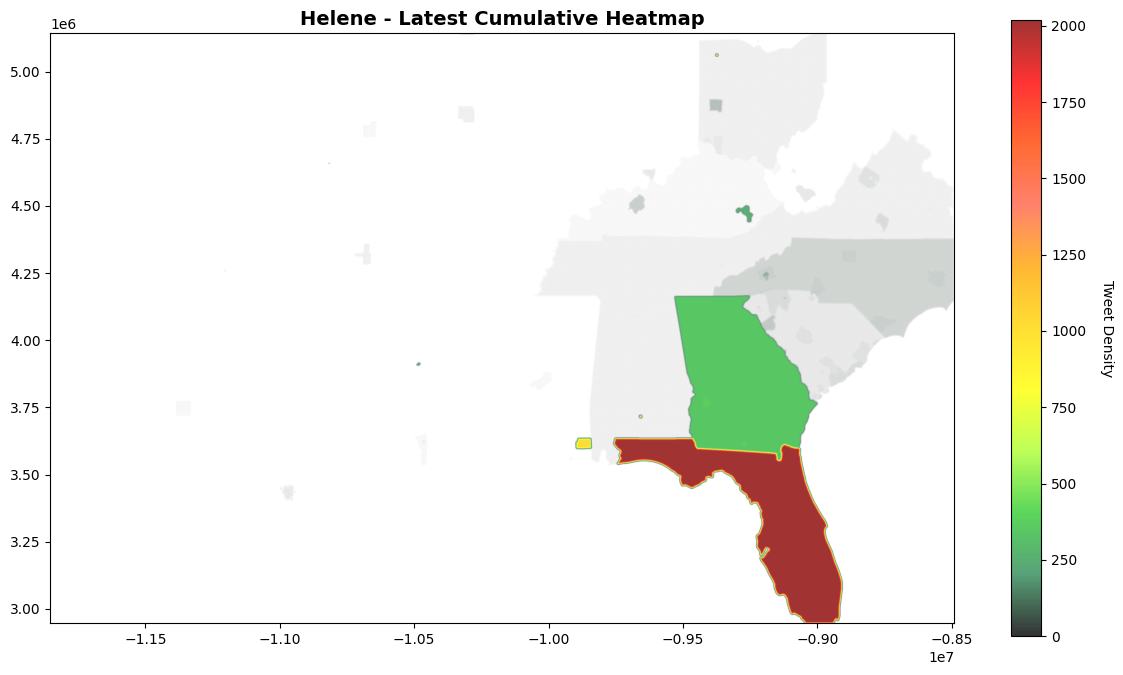

  Data range: 0.0 - 2691.5
  95th percentile: 2018.0
  Non-zero pixels: 2,577,972

✓ HELENE heatmap processing complete!
  Smoothed rasters: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\heatmap
  Styled rasters: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\styled

ALL HEATMAP PROCESSING COMPLETE! 🔥

Next steps:
1. Use 'heatmap' folder rasters for ArcGIS Pro with custom symbology
2. Use 'styled' folder rasters for direct web mapping
3. The preview shows you what the final heatmap looks like!


In [54]:
# PLACE THIS CODE AFTER YOUR RASTER GENERATION IS COMPLETE
# =============================================================================
# HEATMAP POST-PROCESSING AND STYLING
# =============================================================================

import numpy as np
import rasterio
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from rasterio.plot import show
import glob
import os

def apply_heatmap_smoothing(input_raster_path, output_raster_path, sigma_multiplier=2.0):
    """
    Apply gaussian smoothing to create heatmap effect

    Parameters:
    - sigma_multiplier: Controls smoothing intensity (higher = more blur)
    """
    with rasterio.open(input_raster_path) as src:
        data = src.read(1).astype(np.float32)
        profile = src.profile.copy()

        # Apply gaussian filter for heatmap smoothing
        # Sigma is relative to cell size for consistent smoothing
        sigma = sigma_multiplier  # pixels
        smoothed_data = gaussian_filter(data, sigma=sigma, mode='constant', cval=0)

        # Ensure no negative values
        smoothed_data = np.maximum(smoothed_data, 0)

        # Update profile for output
        profile.update(dtype=rasterio.float32, compress='lzw')

        # Write smoothed raster
        with rasterio.open(output_raster_path, 'w', **profile) as dst:
            dst.write(smoothed_data, 1)

    print(f"  Smoothed: {os.path.basename(output_raster_path)}")

    # Return stats
    original_max = np.max(data)
    smoothed_max = np.max(smoothed_data)
    return original_max, smoothed_max

def create_heatmap_versions(hurricane_dir, hurricane_name, sigma=2.0):
    """Create smoothed heatmap versions of all rasters"""
    print(f"\nCreating heatmap versions for {hurricane_name}...")

    # Create heatmap subdirectory
    heatmap_dir = os.path.join(hurricane_dir, 'heatmap')
    os.makedirs(heatmap_dir, exist_ok=True)

    # Process all cumulative rasters (these are usually more interesting for heatmaps)
    cumulative_files = glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_cumulative_*.tif"))

    stats = []
    for tif_path in sorted(cumulative_files):
        filename = os.path.basename(tif_path)
        heatmap_filename = filename.replace('.tif', '_heatmap.tif')
        heatmap_path = os.path.join(heatmap_dir, heatmap_filename)

        orig_max, smooth_max = apply_heatmap_smoothing(tif_path, heatmap_path, sigma)
        stats.append((filename, orig_max, smooth_max))

    print(f"  Created {len(cumulative_files)} heatmap rasters in: {heatmap_dir}")

    # Print smoothing statistics
    print(f"  Smoothing statistics:")
    for filename, orig_max, smooth_max in stats[:3]:  # Show first 3
        print(f"    {filename}: {orig_max:.1f} → {smooth_max:.1f} (max value)")

    return heatmap_dir

def create_heatmap_colormap():
    """Create a heatmap-style colormap like the example image"""
    # Define colors similar to your example image
    colors = [
        '#00000000',  # Transparent (for 0 values)
        '#2E8B57FF',  # Sea Green (low values)
        '#32CD32FF',  # Lime Green
        '#ADFF2FFF',  # Green Yellow
        '#FFFF00FF',  # Yellow
        '#FFD700FF',  # Gold
        '#FFA500FF',  # Orange
        '#FF6347FF',  # Tomato
        '#FF4500FF',  # Orange Red
        '#FF0000FF',  # Red (high values)
        '#8B0000FF',  # Dark Red (highest values)
    ]

    # Create colormap
    n_bins = 256
    cmap = mcolors.LinearSegmentedColormap.from_list('heatmap', colors, N=n_bins)

    return cmap

def preview_heatmap(raster_path, title="Heatmap Preview"):
    """Create a preview of the heatmap with proper styling"""

    with rasterio.open(raster_path) as src:
        data = src.read(1)

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get custom colormap
        cmap = create_heatmap_colormap()

        # Set up visualization
        # Use 95th percentile for max to avoid outliers dominating the scale
        vmax = np.percentile(data[data > 0], 95) if np.any(data > 0) else np.max(data)
        vmin = 0

        # Display raster
        show(src, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8)

        # Styling
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_aspect('equal')

        # Add colorbar
        im = ax.images[0]
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label('Tweet Density', rotation=270, labelpad=20)

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"  Data range: {np.min(data):.1f} - {np.max(data):.1f}")
        print(f"  95th percentile: {vmax:.1f}")
        print(f"  Non-zero pixels: {np.count_nonzero(data):,}")

def export_styled_geotiff(input_path, output_path, apply_colormap=True):
    """Export a styled GeoTIFF with embedded colormap for direct use in web maps"""

    with rasterio.open(input_path) as src:
        data = src.read(1)
        profile = src.profile.copy()

        if apply_colormap:
            # Convert to 8-bit for colormap application
            vmax = np.percentile(data[data > 0], 95) if np.any(data > 0) else np.max(data)
            data_normalized = np.clip((data / vmax) * 255, 0, 255).astype(np.uint8)

            # Update profile for 8-bit output
            profile.update(
                dtype=rasterio.uint8,
                count=1,
                compress='lzw'
            )

            # Write the normalized data
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(data_normalized, 1)

                # Create and write colormap
                cmap = create_heatmap_colormap()
                colormap = {}
                for i in range(256):
                    rgba = cmap(i / 255.0)
                    # Convert to 0-255 range
                    colormap[i] = tuple(int(c * 255) for c in rgba)

                dst.write_colormap(1, colormap)
        else:
            # Keep as float32
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(data, 1)

    print(f"  Exported styled raster: {os.path.basename(output_path)}")

# =============================================================================
# EXECUTE HEATMAP PROCESSING
# =============================================================================

def process_hurricane_heatmaps(hurricane_name, hurricane_dir, preview_latest=True):
    """Complete heatmap processing pipeline for a hurricane"""

    print(f"\n{'='*60}")
    print(f"HEATMAP PROCESSING: {hurricane_name.upper()}")
    print(f"{'='*60}")

    # Step 1: Create smoothed heatmap versions
    heatmap_dir = create_heatmap_versions(hurricane_dir, hurricane_name, sigma=2.5)

    # Step 2: Create web-ready styled versions
    styled_dir = os.path.join(hurricane_dir, 'styled')
    os.makedirs(styled_dir, exist_ok=True)

    heatmap_files = glob.glob(os.path.join(heatmap_dir, "*.tif"))

    for heatmap_file in sorted(heatmap_files):
        filename = os.path.basename(heatmap_file)
        styled_filename = filename.replace('_heatmap.tif', '_styled.tif')
        styled_path = os.path.join(styled_dir, styled_filename)

        export_styled_geotiff(heatmap_file, styled_path, apply_colormap=True)

    # Step 3: Preview the latest heatmap
    if preview_latest and heatmap_files:
        latest_heatmap = sorted(heatmap_files)[-1]
        preview_heatmap(latest_heatmap, f"{hurricane_name.title()} - Latest Cumulative Heatmap")

    print(f"\n✓ {hurricane_name.upper()} heatmap processing complete!")
    print(f"  Smoothed rasters: {heatmap_dir}")
    print(f"  Styled rasters: {styled_dir}")

    return heatmap_dir, styled_dir

# Run processing for your hurricanes
print("\n" + "="*60)
print("HEATMAP POST-PROCESSING")
print("="*60)

# Process both hurricanes
francine_dir = os.path.join(output_dir, 'francine')
helene_dir = os.path.join(output_dir, 'helene')

if os.path.exists(francine_dir):
    francine_heatmap_dir, francine_styled_dir = process_hurricane_heatmaps('francine', francine_dir)

if os.path.exists(helene_dir):
    helene_heatmap_dir, helene_styled_dir = process_hurricane_heatmaps('helene', helene_dir)

print("\n" + "="*60)
print("ALL HEATMAP PROCESSING COMPLETE! 🔥")
print("="*60)
print("\nNext steps:")
print("1. Use 'heatmap' folder rasters for ArcGIS Pro with custom symbology")
print("2. Use 'styled' folder rasters for direct web mapping")
print("3. The preview shows you what the final heatmap looks like!")